# Feature Selection and Reduced Feature Models #

In this notebook I will reduce the number of features used and re-run some models to see if I can get better, or equal results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import Ridge

Read in data set with categorical variables turned into dummy variables

In [2]:
df = pd.read_csv('data/cleaned_data/md_dum.csv')

# create X and y values for modeling, using a mask to create 1 and 0 values for classification
car_y = df.car_acc_score
car_c_y = df.car_acc_score.mask(df.car_acc_score > 0, 1)
car_X = df.drop(columns=['Unnamed: 0', 'car_acc_score', 'car_dens_score', 'bike_dens_score'])
bike_y = df.bike_acc_score
bike_c_y = df.bike_acc_score.mask(df.bike_acc_score > 0, 1)
bike_X = df.drop(columns=['Unnamed: 0', 'bike_acc_score', 'car_dens_score', 'bike_dens_score'])

In [3]:
len(car_X.columns)

210

Do train test split on classification

In [4]:
# train test split
X_car_c_train, X_car_c_test, y_car_c_train, y_car_c_test = train_test_split(car_X, car_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=car_c_y)
X_bike_c_train, X_bike_c_test, y_bike_c_train, y_bike_c_test = train_test_split(bike_X, bike_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=bike_c_y)

Perform decision tree classifier on car data

In [5]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_car_c_train, y_car_c_train)
dtc.score(X_car_c_test, y_car_c_test)

0.8872599721185411

Show the top 20 features for car classifying.

In [6]:
car_feature_importances = dtc.feature_importances_
car_feature_names, car_feature_scores = zip(*sorted(zip(X_car_c_train.columns, car_feature_importances), 
                                                          key=lambda x: -x[1]))
car_features = pd.DataFrame({'feature_names' : car_feature_names, 'score' : car_feature_scores}).set_index('feature_names').sort_values(by='score')
car_features.tail(20)

,score
feature_names,
Jurisdictn_2,0.002013
Struct_Cnd_3,0.002031
Route_System_L,0.002605
Op_Dir_SL,0.002669
Route_Direction_NB,0.002675
City_Maint_35,0.002739
Terrain_1,0.002772
Route_Direction_EB,0.002788
Med_Width,0.002877


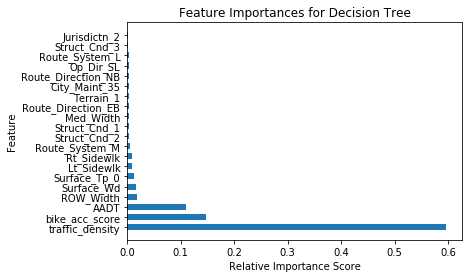

In [7]:
y_position = list(range(len(car_feature_names[:20])))
plt.barh(y_position, car_feature_scores[:20], height=0.6, align='center')
plt.yticks(y_position , car_feature_names[:20])
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

These contain several categorical dummy columns, so I'm going to create a new dataframe with dummy variables for the categorical data that is most important.

In [9]:
#build smaller feature set
#read in data set before making dummies
sel_df = pd.read_csv('data/cleaned_data/model_df.csv')
sel_df = sel_df[['car_acc_score', 'traffic_density', 'bike_acc_score', 'AADT', 'ROW_Width', 'Surface_Wd', 'Surface_Tp', 
                'Rt_Sidewlk', 'Lt_Sidewlk', 'Route_System', 'Route_Direction', 'Struct_Cnd', 'Terrain',
                'Route_System', 'Med_Width', 'City_Maint', 'Jurisdictn', 'Op_Dir_SL']]
sel_dum = pd.get_dummies(sel_df, columns=['Route_System', 'Route_Direction', 'Struct_Cnd', 'Terrain', 'Surface_Tp',
                'Route_System', 'City_Maint', 'Jurisdictn'])
sel_dum.head()

,car_acc_score,traffic_density,bike_acc_score,AADT,ROW_Width,Surface_Wd,Rt_Sidewlk,Lt_Sidewlk,Med_Width,Op_Dir_SL,...,City_Maint_274,City_Maint_314,Jurisdictn_0,Jurisdictn_1,Jurisdictn_2,Jurisdictn_3,Jurisdictn_5,Jurisdictn_B,Jurisdictn_E,Jurisdictn_H
0,1,1.707255,10,1154.0,50.0,28.0,4.0,4.0,0.0,30,...,0,0,0,0,1,0,0,0,0,0
1,0,0.186701,4,1154.0,50.0,28.0,4.0,4.0,0.0,30,...,0,0,0,0,1,0,0,0,0,0
2,0,0.345786,1,1154.0,50.0,28.0,4.0,4.0,0.0,30,...,0,0,0,0,1,0,0,0,0,0
3,1,0.470252,10,3598.0,55.0,30.0,5.0,5.0,0.0,99,...,0,0,0,0,1,0,0,0,0,0
4,0,2.013781,1,3598.0,55.0,30.0,5.0,5.0,0.0,99,...,0,0,0,0,1,0,0,0,0,0


In [10]:
len(sel_dum.columns)

88

Now lets see if my best regressor runs any better on this reduced set

In [11]:
car_y = sel_dum.car_acc_score
car_X = sel_dum.drop(columns=['car_acc_score'])
# do train test split
X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(car_X, car_y, test_size=0.3, random_state=18,
                                                                   shuffle=True, stratify=car_y)

In [12]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_car_train, y_car_train)
car_score = rfr.score(X_car_test, y_car_test)
print('Random Forest Regression Score on car accidents: {}'.format(car_score))

Random Forest Regression Score on car accidents: 0.14138852623687082


That is definitely better than before, 0.1, but not wildly better. Let's try our best linear regressor.

In [13]:
ri = Ridge()
ri.fit(X_car_train, y_car_train)
ri_score = ri.score(X_car_test, y_car_test)
print('Ridge Regression Score on car accidents is: {}'.format(ri_score))

Ridge Regression Score on car accidents is: 0.05771563677915259


Not much better. Okay, classification still seems like the better bet.

In [14]:
car_c_y = sel_dum.car_acc_score.mask(sel_dum.car_acc_score > 0, 1)

# do train test split
X_car_c_train, X_car_c_test, y_car_c_train, y_car_c_test = train_test_split(car_X, car_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=car_c_y)

In [15]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_car_c_train, y_car_c_train)
dtc.score(X_car_c_test, y_car_c_test)

0.8876647029725233

In [16]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_car_c_train, y_car_c_train)
score = rfc.score(X_car_c_test, y_car_c_test)
print('Random Forest Classifier accuracy score is {}'.format(score))

Random Forest Classifier accuracy score is 0.8894185366731123


In [17]:
bc = ensemble.BaggingClassifier()
bc.fit(X_car_c_train, y_car_c_train)
score = bc.score(X_car_c_test, y_car_c_test)
print('Bagging Classifier accuracy score is {}'.format(score))

Bagging Classifier accuracy score is 0.8932859648333858


Gradient Boosting Score: 0.8843369159508927
[[11364  1119]
 [ 1453  8301]]


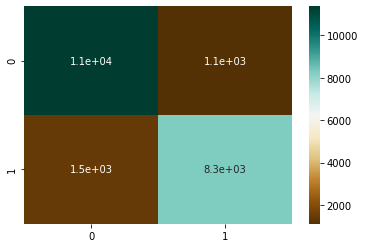

In [18]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_car_c_train, y_car_c_train)
print('Gradient Boosting Score: {}'.format(gbc.score(X_car_c_test, y_car_c_test)))
pred = gbc.predict(X_car_c_test)
c=confusion_matrix(y_car_c_test, pred)
print(c)
sns.heatmap(c,cmap='BrBG',annot=True)
plt.show()

The important features for predicting bike accidents will certainly be different than for cars, so I will create a new reduced feature data frame.

In [7]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_bike_c_train, y_bike_c_train)
dtc.score(X_bike_c_test, y_bike_c_test)

0.9025947744749742

In [8]:
# show the top 20 features for bike classifying
bike_feature_importances = dtc.feature_importances_
bike_feature_names, bike_feature_scores = zip(*sorted(zip(X_bike_c_train.columns, bike_feature_importances), 
                                                          key=lambda x: -x[1]))
bike_features = pd.DataFrame({'feature_names' : bike_feature_names, 'score' : bike_feature_scores}).set_index('feature_names').sort_values(by='score')
bike_features.tail(20)

,score
feature_names,
F_Class_3,0.003079
Struct_Cnd_1,0.003356
Route_Direction_NB,0.003434
Operation_1,0.003523
Operation_-1,0.003628
Terrain_1,0.003792
Operation_2,0.004376
Op_Dir_SL,0.005211
Med_Width,0.005771


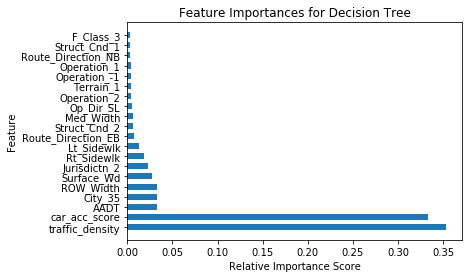

In [10]:
y_position = list(range(len(bike_feature_names[:20])))
plt.barh(y_position, bike_feature_scores[:20], height=0.6, align='center')
plt.yticks(y_position , bike_feature_names[:20])
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

Build the smaller feature set for predicting bike accidents.

In [20]:
#build smaller feature set
#read in data set before making dummies
bike_df = pd.read_csv('data/cleaned_data/model_df.csv')
bike_df = bike_df[['car_acc_score', 'bike_acc_score', 'AADT', 'City', 'ROW_Width', 'Surface_Wd', 
                 'Jurisdictn', 'Rt_Sidewlk', 'Lt_Sidewlk', 'Route_Direction', 'Med_Width',
                 'Op_Dir_SL', 'Struct_Cnd', 'Operation', 'Terrain', 'F_Class']]
bike_dum = pd.get_dummies(bike_df, columns=['City', 'Jurisdictn', 'Route_Direction', 'Struct_Cnd',
                                         'Operation', 'Terrain', 'F_Class'])
bike_dum.head()

,car_acc_score,bike_acc_score,AADT,ROW_Width,Surface_Wd,Rt_Sidewlk,Lt_Sidewlk,Med_Width,Op_Dir_SL,City_-1,...,Terrain_1,Terrain_2,Terrain_3,F_Class_-1,F_Class_0,F_Class_1,F_Class_2,F_Class_3,F_Class_5,F_Class_6
0,1,10,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
1,0,4,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
3,1,10,3598.0,55.0,30.0,5.0,5.0,0.0,99,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,3598.0,55.0,30.0,5.0,5.0,0.0,99,0,...,1,0,0,0,0,0,0,0,0,1


Now lets see if my best regressor runs any better on this reduced set

In [21]:
len(bike_dum.columns)

54

In [22]:
bike_y = bike_dum.bike_acc_score
bike_X = bike_dum.drop(columns=['bike_acc_score'])
# do train test split
X_bike_train, X_bike_test, y_bike_train, y_bike_test = train_test_split(bike_X, bike_y, test_size=0.3, random_state=18,
                                                              shuffle=True, stratify=bike_y)

In [23]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_bike_train, y_bike_train)
bike_score = rfr.score(X_bike_test, y_bike_test)
print('Random Forest Regression Score on car accidents: {}'.format(bike_score))

Random Forest Regression Score on car accidents: 0.3120752306365565


In [24]:
ri = Ridge()
ri.fit(X_bike_train, y_bike_train)
ri_score = ri.score(X_bike_test, y_bike_test)
print('Ridge Regression Score on car accidents is: {}'.format(ri_score))

Ridge Regression Score on car accidents is: 0.07096354190730414


Random Forest Regressor runs better on the reduced data set than any other regression on bike accident data but it's still not accurate enough to be worth much.

Continuing with classification models.

In [25]:
bike_c_y = bike_dum.bike_acc_score.mask(bike_dum.bike_acc_score > 0, 1)

# do train test split
X_bike_c_train, X_bike_c_test, y_bike_c_train, y_bike_c_test = train_test_split(bike_X, bike_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=bike_c_y)

In [26]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_bike_c_train, y_bike_c_train)
dtc.score(X_bike_c_test, y_bike_c_test)

0.8101362593875073

In [27]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_bike_c_train, y_bike_c_train)
score = rfc.score(X_bike_c_test, y_bike_c_test)
print('Random Forest Classifier accuracy score is {}'.format(score))

Random Forest Classifier accuracy score is 0.8129244052704951


In [28]:
bc = ensemble.BaggingClassifier()
bc.fit(X_bike_c_train, y_bike_c_train)
score = bc.score(X_bike_c_test, y_bike_c_test)
print('Bagging Classifier accuracy score is {}'.format(score))

Bagging Classifier accuracy score is 0.8126096146062868


In [29]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_bike_c_train, y_bike_c_train)
score = gbc.score(X_bike_c_test, y_bike_c_test)
print('Gradient Boosting Classifier accuracy score is {}'.format(score))

Gradient Boosting Classifier accuracy score is 0.8018617619283177
